# Telecom. Customer churn forecasting

A telecom operator wants to learn how to predict customer churn.
If it turns out that the user plans to leave, he will be offered promotional codes and special conditions. The operator's team collected personal data about some customers, information about their tariffs and contracts.

### Description of services

The operator provides two main types of services:
- Fixed telephone connection. It is possible to connect a telephone set to several lines at the same time
- Internet. The connection can be of two types: via a DSL telephone line (from the English *digital subscriber line* - "digital subscriber line") or fiber optic cable (*Fiber optic*)

The following services are also available:
- Internet security: antivirus (*DeviceProtection*) and blocking of unsafe sites (*OnlineSecurity*)
- Dedicated technical support line (*TechSupport*)
- Cloud file storage for data backup (*OnlineBackup*)
- Streaming TV (*StreamingTV*) and movie catalog (*StreamingMovies*)

Clients can pay for services every month or sign a contract for 1-2 years. Various payment methods and the possibility of receiving an electronic receipt for services are available

### Description of data

The data is stored in tables in a PostgreSQL database:
- `contract` — information about the contract
- `personal` - personal data of the client
- `internet` - information about Internet services
- `phone` — information about telephony services

**Table `telecom.contract`**
- `customerID` 
- `BeginDate`
- `EndDate`
- `Type`
- `PaperlessBilling` 
- `PaymentMethod`
- `MonthlyCharges` 
- `TotalCharges`

**Table `telecom.personal`**
- `customerID`
- `gender`
- `SeniorCitizen` 
- `Partner` 
- `Dependents`

**Table `telecom.internet`**
- `customerID`
- `InternetService` 
- `OnlineSecurity`
- `OnlineBackup`
- `DeviceProtection`
- `TechSupport`
- `StreamingTV`
- `StreamingMovies`

**Table `telecom.phone`**
- `customerID` 
- `MultipleLines` 

Information about contracts is current as of February 1, 2020.

In [1]:
import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:

    !pip install catboost
    !pip install ipywidgets
    !jupyter nbextension enable --py widgetsnbextension

    print('Environment: Google Colab')

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime
import math

from sqlalchemy import create_engine 
import phik

import torch
import torch.nn as nn

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool, cv
from catboost.utils import get_confusion_matrix

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

## Read data

Connecting to the database

In [3]:
db_config = {
'user': 'praktikum_student',
'pwd': 'Sdf4$2;d-d30pp', 
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432,
'db': 'data-science-final'
} 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Create a connection

In [4]:
engine = create_engine(connection_string) 

In [5]:
query = '''
SELECT table_name, table_schema FROM information_schema.tables 
'''
sample_df = pd.read_sql_query(query, con=engine) 

In [6]:
sample_df.head(15)

,table_name,table_schema
0,data_arc,steel
1,data_bulk,steel
2,data_bulk_time,steel
3,data_gas,steel
4,data_temp,steel
5,data_wire,steel
6,data_wire_time,steel
7,personal,telecom
8,phone,telecom
9,contract,telecom


The database has all the tables specified in the condition and they are in the telecom schema, let's save them in csv.

In [7]:
lst = {'contract', 'personal', 'internet', 'phone'}

In [8]:
for i in lst:
    try:
        df_temp = pd.read_csv('{}.csv'.format(i))
    except Exception as e:
        query = '''SELECT * FROM telecom.{}'''.format(i)
        df_temp = pd.read_sql_query(query, con=engine) 
        df_temp.to_csv('{}.csv'.format(i))
        print('table {} has been saved'.format(i))

Next, we will save these tables into Pandas

In [9]:
df_contract = pd.read_csv('contract.csv', index_col = 0)
df_personal = pd.read_csv('personal.csv', index_col = 0)
df_internet = pd.read_csv('internet.csv', index_col = 0, header = 1)
df_phone = pd.read_csv('phone.csv', index_col = 0, header = 1)

df_internet = df_internet.reset_index(drop = True)
df_phone = df_phone.reset_index(drop = True)

display(df_contract.head(3))
display(df_personal.head(3))
display(df_internet.head(3))
display(df_phone.head(3))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,NaN,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,NaN,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No


Note that the `customerID` column is present in all tables - a common key for all data

In [10]:
df_personal = df_personal.rename({'gender': 'Gender'}, axis=1)
df_personal.head(3)

,customerID,Gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No


In [11]:
lst_df = {'df_contract': df_contract, 
          'df_personal': df_personal, 
          'df_internet': df_internet, 
          'df_phone': df_phone}

for i in lst_df:
    print('Number of rows in table {} - {}, number of columns - {}'.format(i, lst_df[i].shape[0], lst_df[i].shape[1]))

Number of rows in table df_contract - 7043, number of columns - 8
Number of rows in table df_personal - 7043, number of columns - 5
Number of rows in table df_internet - 5517, number of columns - 8
Number of rows in table df_phone - 6361, number of columns - 2


**Conclusion:**

- created a connection to the database in SQL
- saved data in csv and read it in Pandas
- look at the total number of records and columns for each table

## Explanatory data analysis

### Preprocessing and searching for insights in data

Next, I propose to assemble a single master table with all the signs of client activity (we identified the common key for data earlier).
But first, let's check our data for obvious duplicates.

In [12]:
for i in lst_df:
    print('Number of obvious duplicates in table {} - {}'.format(i, lst_df[i].duplicated().sum())) 

Number of obvious duplicates in table df_contract - 0
Number of obvious duplicates in table df_personal - 0
Number of obvious duplicates in table df_internet - 0
Number of obvious duplicates in table df_phone - 0


We can combine all the data and not worry about the appearance of extra rows.
Also note that the number of rows in the tables `df_internet` and `df_internet` is less than in the table with client data, this can be explained by the fact that not all clients use the services from these tables (Internet or voice communication)

In [13]:
df = (df_contract.merge(df_personal, on = 'customerID', how='left')
              .merge(df_internet, on = 'customerID', how='left')
              .merge(df_phone, on = 'customerID', how='left'))
df.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,4472-LVYGI,2020-02-01,NaN,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
1,3115-CZMZD,2020-02-01,NaN,Two year,No,Mailed check,20.25,NaN,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No


For convenience, we convert Camel Case to Snake Case

In [14]:
column_lst = []
cond = re.compile('((?<=[a-z0-9])[A-Z]|(?!^)[A-Z](?=[a-z]))')
for i in df.columns:
    column_lst += [cond.sub(r'_\1', i).lower()]
column_lst[:3]

['customer_id', 'begin_date', 'end_date']

In [15]:
df.columns = column_lst

Now let's look at the general information about the collected table

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           1869 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7032 non-null   float64
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  online_backup      5517 non-null   object 
 15  device_protection  5517 non-null   object 
 16  tech_support       5517 

In [17]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
monthly_charges,7043.0,64.761692,30.090047,18.25,35.50,70.350,89.8500,118.75
total_charges,7032.0,2283.300441,2266.771362,18.80,401.45,1397.475,3794.7375,8684.80
senior_citizen,7043.0,0.162147,0.368612,0.00,0.00,0.000,0.0000,1.00


I suggest the following steps:
- designate a target feature based on `end_date`
- process passes
- to study quantitative and categorical features

**Target feature**

We predict churn and therefore if the `end_date` field is filled, it is necessary to put down 1,
it is also important to remember that all data is for February 1, 2020

In [18]:
df['churn'] = np.where(df['end_date'].isnull() == True, 1, 0)
df['churn'].value_counts()

1    5174
0    1869
Name: churn, dtype: int64

We see an imbalance in classes, and in our data there are more clients who closed contracts.

**We will process the omission**

Output columns containing nan-values and then examine each column

In [19]:
df.columns[df.isna().any()].tolist()

['end_date',
 'total_charges',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines']

- `end_date` - contract closing date:
   - not filled out because the contract is still active
   - knowing `begin_date` we can add the `contract_term` field

In [20]:
df['end_date'] = (df['end_date'].fillna('2020-02-01'))

df['end_date'] = pd.to_datetime(df['end_date'])
df['begin_date'] = pd.to_datetime(df['begin_date'])

df['contract_term'] = (pd.to_datetime(df['end_date']) - pd.to_datetime(df['begin_date'])).dt.days.astype('int')

df = df.drop(['begin_date','end_date'], axis = 1)

- `total_charges` - user's total charges
   - not filled because the client has just registered and did not have time to spend anything
   - a technical error and we need to think about how to fill in the gaps

In [21]:
df[df['total_charges'].isna() == True]

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churn,contract_term
0,4472-LVYGI,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN,1,0
1,3115-CZMZD,Two year,No,Mailed check,20.25,NaN,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,1,0
3,5709-LVOEQ,Two year,No,Mailed check,80.85,NaN,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No,1,0
6,4367-NUYAO,Two year,No,Mailed check,25.75,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,1,0
7,1371-DWPAZ,Two year,No,Credit card (automatic),56.05,NaN,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN,1,0
9,3213-VVOLG,Two year,No,Mailed check,25.35,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,1,0
10,2923-ARZLG,One year,Yes,Mailed check,19.70,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,1,0
11,2775-SEFEE,Two year,Yes,Bank transfer (automatic),61.90,NaN,Male,0,No,Yes,DSL,Yes,Yes,No,Yes,No,No,Yes,1,0
4408,7644-OMVMY,Two year,No,Mailed check,19.85,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,1,0
5160,2520-SGTTA,Two year,No,Mailed check,20.00,NaN,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,1,0


The client registered and terminated the contract on the same day.
Fill in `total_charges` - 0.

In [22]:
df['total_charges'] = (df['total_charges'].fillna(0))

The following group of columns with gaps will be considered together:

- `internet_service`
- `online_security`
- `online_backup`
- `device_protection`
- `tech_support`
- `streaming_tv`
- `streaming_movies`
- `multiple_lines`

These are additional options and services within the framework of voice communication and Internet services.
- `multiple_lines` column from `telecom.phone` table
- others from `telecom.internet`

And, as I said above, if the field is not filled in for the client, the client simply did not connect these services.

We need to fill in the omissions with *No*

In [23]:
df = df.fillna('No')

In [24]:
print('Number of rows with omissions in the resulting table -', df.isnull().sum().sum())

Number of rows with omissions in the resulting table - 0


**Let's study quantitative and categorical features**

At the moment, we have 20 features in the sample, of which:
- `customer_id` - customer ID, not considered in EDA
- quantitative features monthly_charges, total_charges, contract_term
- all others are categorical features

In [25]:
numerical_cols = ['monthly_charges', 'total_charges', 'contract_term']
cat_cols = df.columns[~(df.columns.isin(numerical_cols + ['customer_id']))]

print('Numerical Values {} are : {}'.format(len(numerical_cols), numerical_cols))
print('')
print('Categorical Values {} are : {}'.format(len(cat_cols), cat_cols))

Numerical Values 3 are : ['monthly_charges', 'total_charges', 'contract_term']

Categorical Values 16 are : Index(['type', 'paperless_billing', 'payment_method', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines', 'churn'],
      dtype='object')


Let's print the number of unique values:

In [26]:
for i in numerical_cols:
    print(i, len(df[i].unique()))

monthly_charges 1585
total_charges 6531
contract_term 476


In [27]:
for i in cat_cols:
    print(i, len(df[i].unique()))

type 3
paperless_billing 2
payment_method 4
gender 2
senior_citizen 2
partner 2
dependents 2
internet_service 3
online_security 2
online_backup 2
device_protection 2
tech_support 2
streaming_tv 2
streaming_movies 2
multiple_lines 2
churn 2


There are not many values, so only OHE coding is applicable at the data preparation stage for model training.

Let's see the unique values of categorical features

In [28]:
for i in cat_cols:
    print(f'Column name: {i}')
    print()
    print((df[i].unique()))
    print('===========================')

Column name: type

['Two year' 'Month-to-month' 'One year']
Column name: paperless_billing

['Yes' 'No']
Column name: payment_method

['Bank transfer (automatic)' 'Mailed check' 'Electronic check'
 'Credit card (automatic)']
Column name: gender

['Female' 'Male']
Column name: senior_citizen

[0 1]
Column name: partner

['Yes' 'No']
Column name: dependents

['Yes' 'No']
Column name: internet_service

['DSL' 'No' 'Fiber optic']
Column name: online_security

['Yes' 'No']
Column name: online_backup

['No' 'Yes']
Column name: device_protection

['Yes' 'No']
Column name: tech_support

['Yes' 'No']
Column name: streaming_tv

['Yes' 'No']
Column name: streaming_movies

['No' 'Yes']
Column name: multiple_lines

['No' 'Yes']
Column name: churn

[1 0]


Let's build histograms and look at the feature distributions:

CPU times: user 112 ms, sys: 2.42 ms, total: 114 ms
Wall time: 125 ms


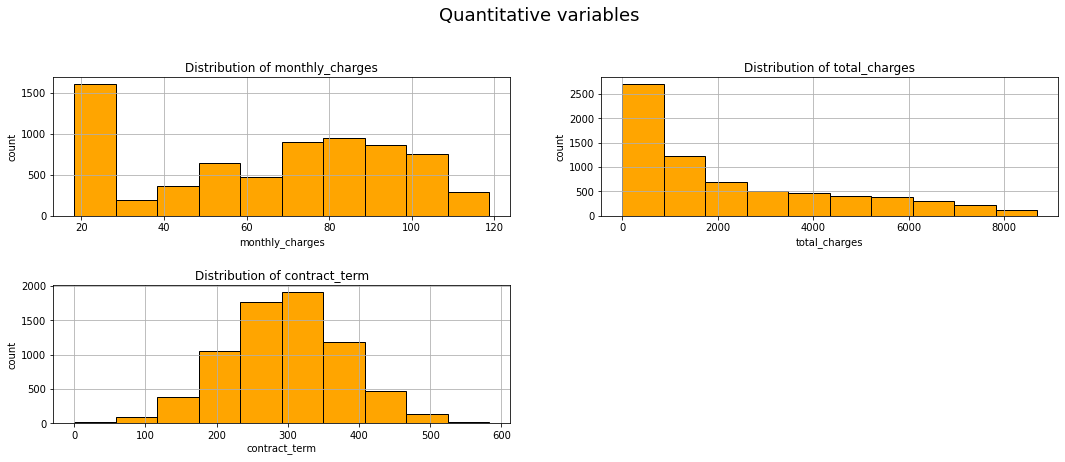

In [29]:
%%time


plt.figure(figsize = (18, 14))
plt.subplots_adjust(hspace = 0.5)
plt.suptitle("Quantitative variables", fontsize = 18, y = 0.95)

for n, ct in enumerate(numerical_cols):
    ax = plt.subplot(4, 2, n + 1)
    ax = plt.hist(df[ct], color = 'orange', edgecolor= 'black')
    plt.title(f'Distribution of {ct}')
    plt.xlabel(ct)
    plt.ylabel('count')
    plt.grid(True)

Earlier, we indicated the imbalance of classes - the number of clients who closed contracts prevails in the total sample.

The pattern in the distribution schedules in `monthly_charges` and `total_charges` looks strange, probably customers who pay more monthly have a shorter contract duration (the retention problem is most relevant for them)

Let's add a partition based on churn.

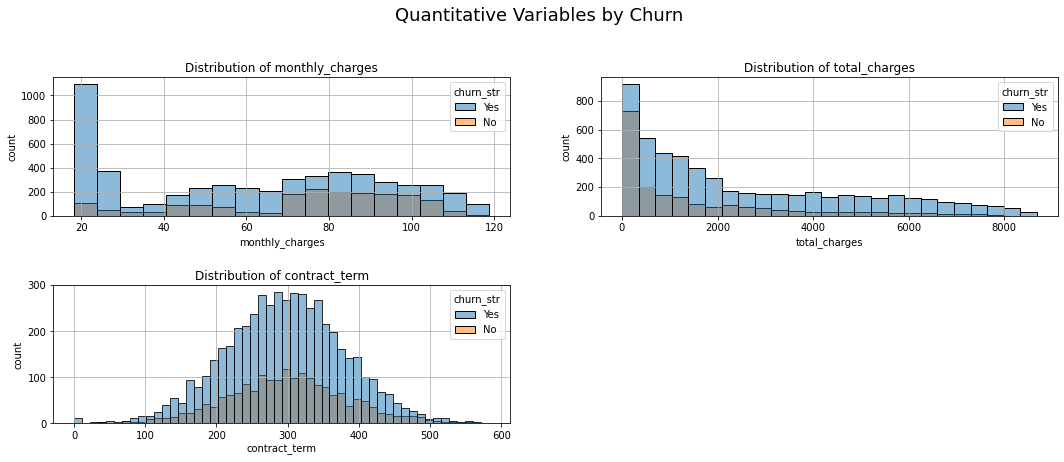

In [30]:
df['churn_str'] = np.where(df['churn'] == 1, 'Yes', 'No')

plt.figure(figsize = (18, 14))
plt.subplots_adjust(hspace = 0.5)
plt.suptitle("Quantitative Variables by Churn", fontsize = 18, y = 0.95)

for n, ct in enumerate(numerical_cols):
    ax = plt.subplot(4, 2, n + 1)
    ax = sns.histplot(data=df, x=ct, hue="churn_str")
    plt.title(f'Distribution of {ct}')
    plt.xlabel(ct)
    plt.ylabel('count')
    plt.grid(True)


plt.grid(True)
plt.show()

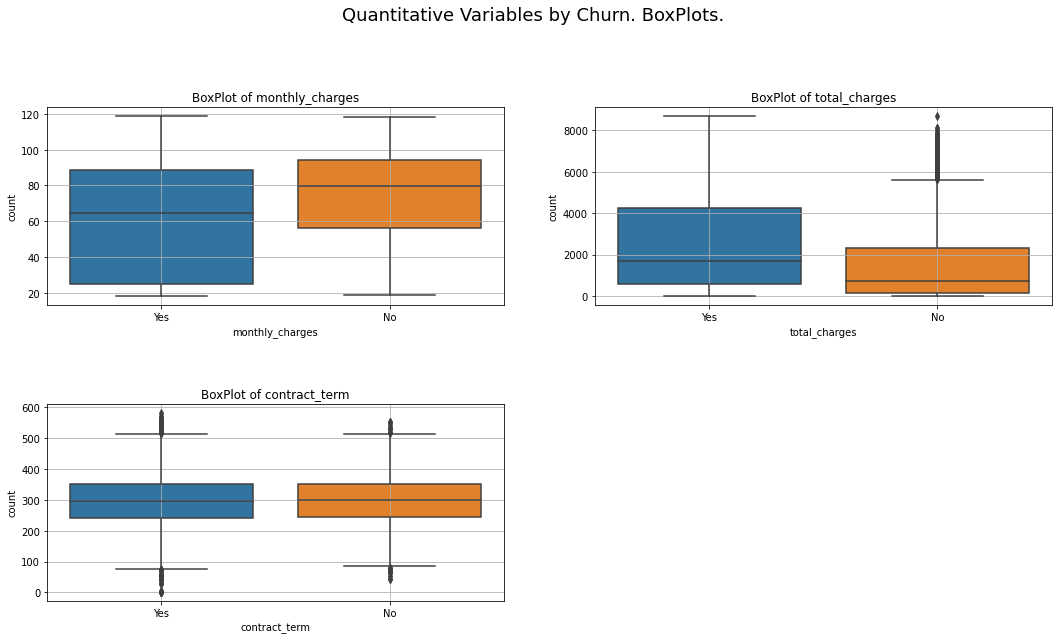

In [31]:
plt.figure(figsize = (18, 20))
plt.subplots_adjust(hspace = 0.5)
plt.suptitle("Quantitative Variables by Churn. BoxPlots.", fontsize = 18, y = 0.95)

for n, ct in enumerate(numerical_cols):
    ax = plt.subplot(4, 2, n + 1)
    ax = sns.boxplot(data = df, y = ct, x = 'churn_str')
    plt.title(f'BoxPlot of {ct}')
    plt.xlabel(ct)
    plt.ylabel('count')
    plt.grid(True)


plt.grid(True)
plt.show()

- the churn is characterized by a large number of cheaper contracts, and the median value of the monthly payment for the churn is less

CPU times: user 612 ms, sys: 3.77 ms, total: 616 ms
Wall time: 610 ms


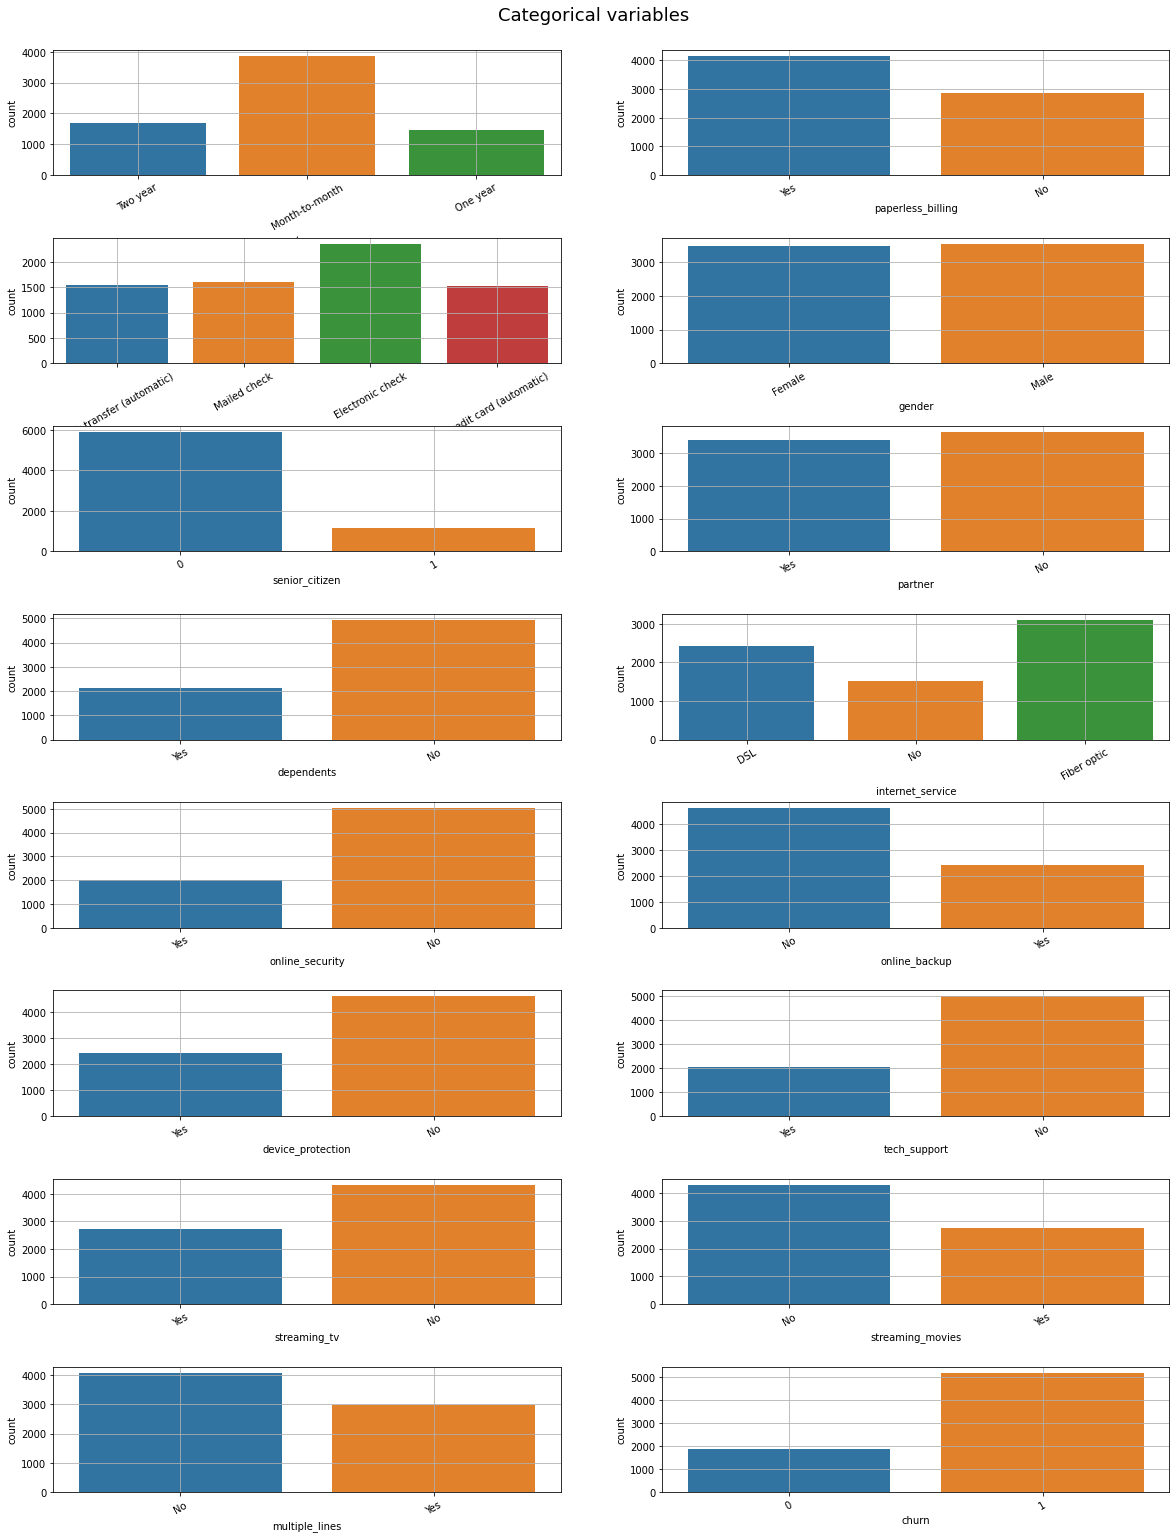

In [32]:
%%time

plt.figure(figsize = (20, 30))
plt.subplots_adjust(hspace = 0.5)
plt.suptitle("Categorical variables", fontsize = 18,  y=0.9)

for n, ct in enumerate(cat_cols):
    ax = plt.subplot(9, 2, n + 1)
    sns.countplot(x = df[ct], ax = ax)
    ax.tick_params(axis = 'x', labelrotation = 30)
    plt.grid(True)

- based on the distributions shown, we see that the share of users of additional options to tariffs is much less than without them
- the most simple, basic tariffs and services prevail

We will also add a distribution by the churn

CPU times: user 1.75 s, sys: 10.3 ms, total: 1.76 s
Wall time: 1.75 s


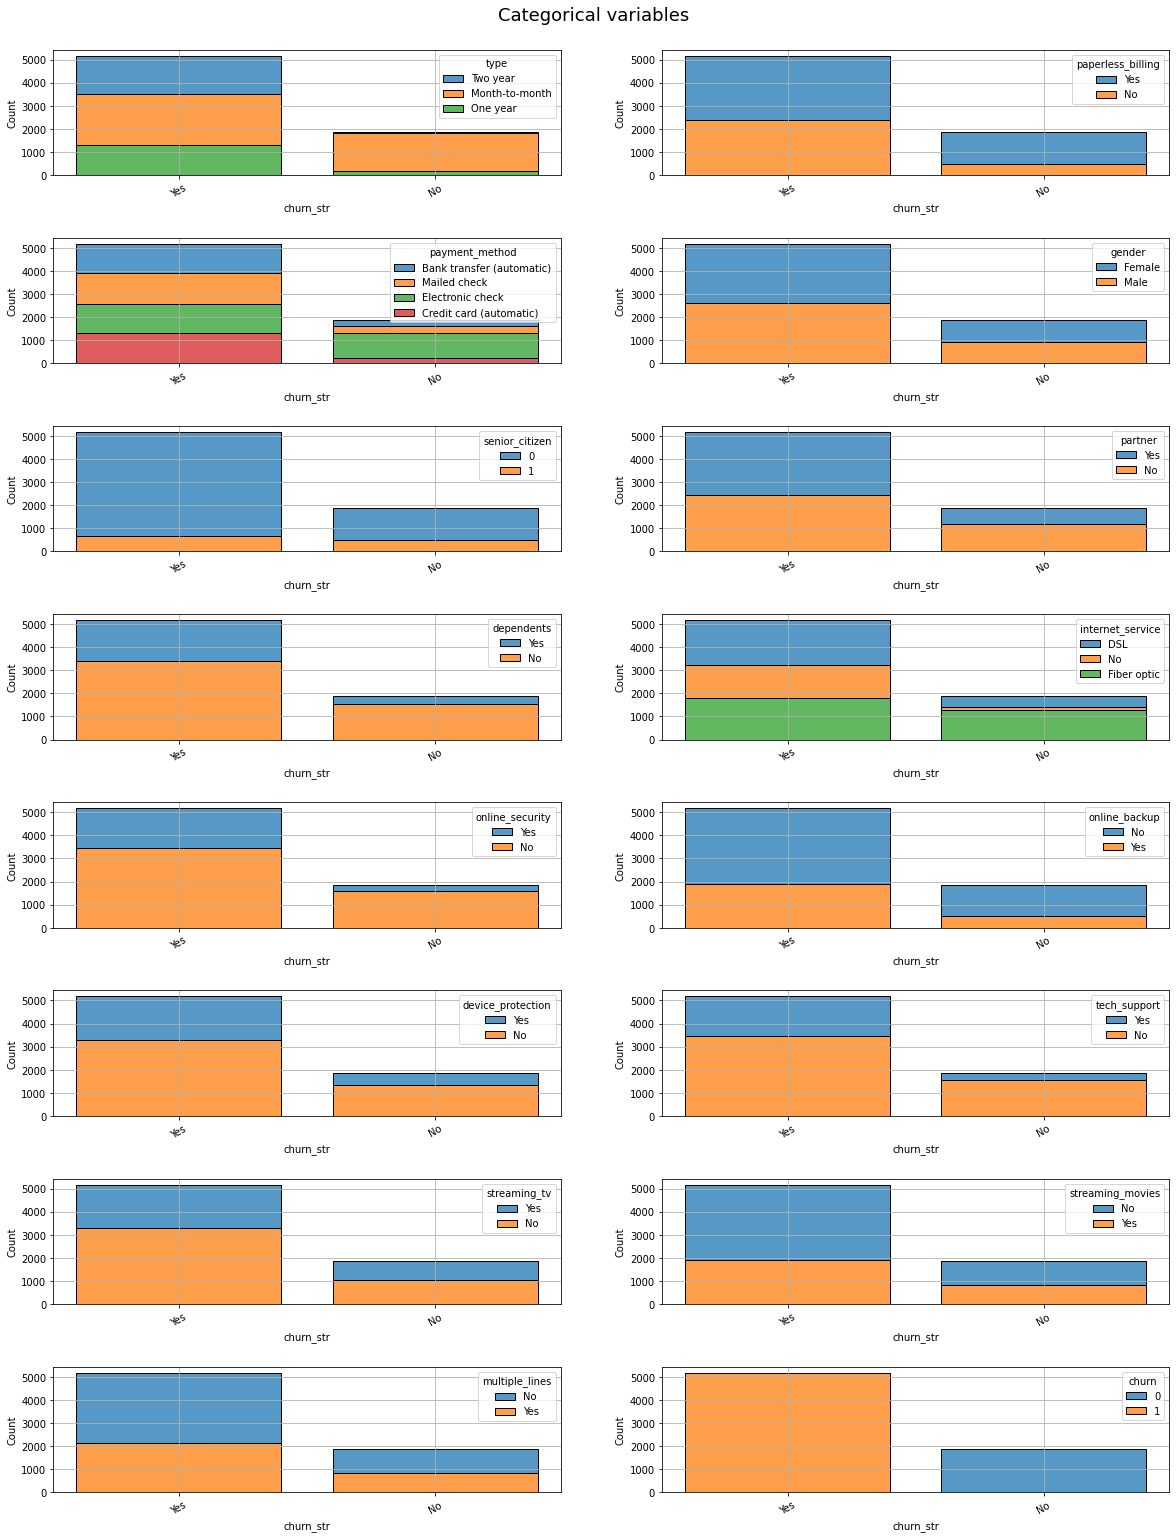

In [33]:
%%time

plt.figure(figsize = (20, 30))
plt.subplots_adjust(hspace = 0.5)
plt.suptitle("Categorical variables", fontsize = 18,  y=0.9)

for n, ct in enumerate(cat_cols):
    ax = plt.subplot(9, 2, n + 1)
    sns.histplot(df, x='churn_str', hue=ct, multiple='stack', shrink=.8, ax = ax)
    ax.tick_params(axis = 'x', labelrotation = 30)
    plt.grid(True)

In [34]:
### check
df.groupby(['churn_str','internet_service'], as_index = False).count()[['churn_str','internet_service','customer_id']]

,churn_str,internet_service,customer_id
0,No,DSL,459
1,No,Fiber optic,1297
2,No,No,113
3,Yes,DSL,1962
4,Yes,Fiber optic,1799
5,Yes,No,1413


In [35]:
### check
df.groupby(['churn_str','type'], as_index = False).count()[['churn_str','type','customer_id']]

,churn_str,type,customer_id
0,No,Month-to-month,1655
1,No,One year,166
2,No,Two year,48
3,Yes,Month-to-month,2220
4,Yes,One year,1307
5,Yes,Two year,1647


- for those who pay monthly, the percentage of churn is approximately equal, and among payments for a year or two, we can observe an outflow (`type`)
- non-internet clients are most rejected (`internet_service`)
- with DSL, the story is similar, perhaps the operator stops providing services without Internet packages or is focused on customers using the Internet (`internet_service`)
- additional services have almost no impact on the target

**Build a correlation matrix**

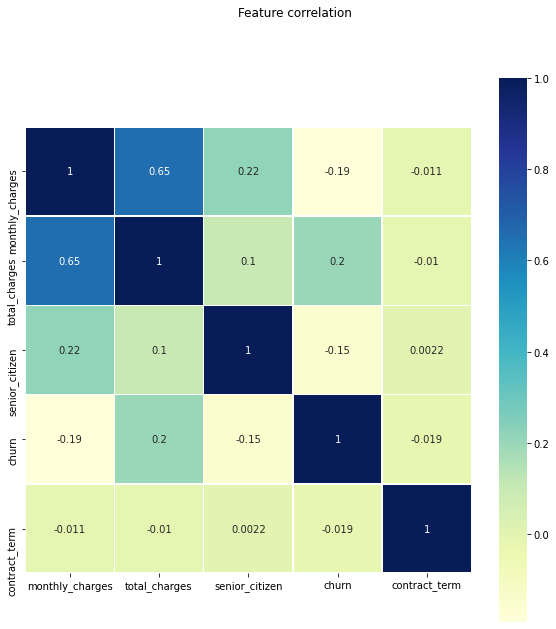

In [36]:
fig, ax = plt.subplots(figsize = (10,10))    

sns.heatmap(df.corr(), annot = True, linewidths=.5, cmap="YlGnBu", square=True, ax = ax)
plt.suptitle("Feature correlation")
plt.show()

The relationship between the monthly payment and the total value of the contract looks logical, I suggest leaving everything as it is, without removing columns.

In [37]:
df_cat = df[cat_cols]
phik_mtrx = df_cat.phik_matrix()

interval columns not set, guessing: ['senior_citizen', 'churn']


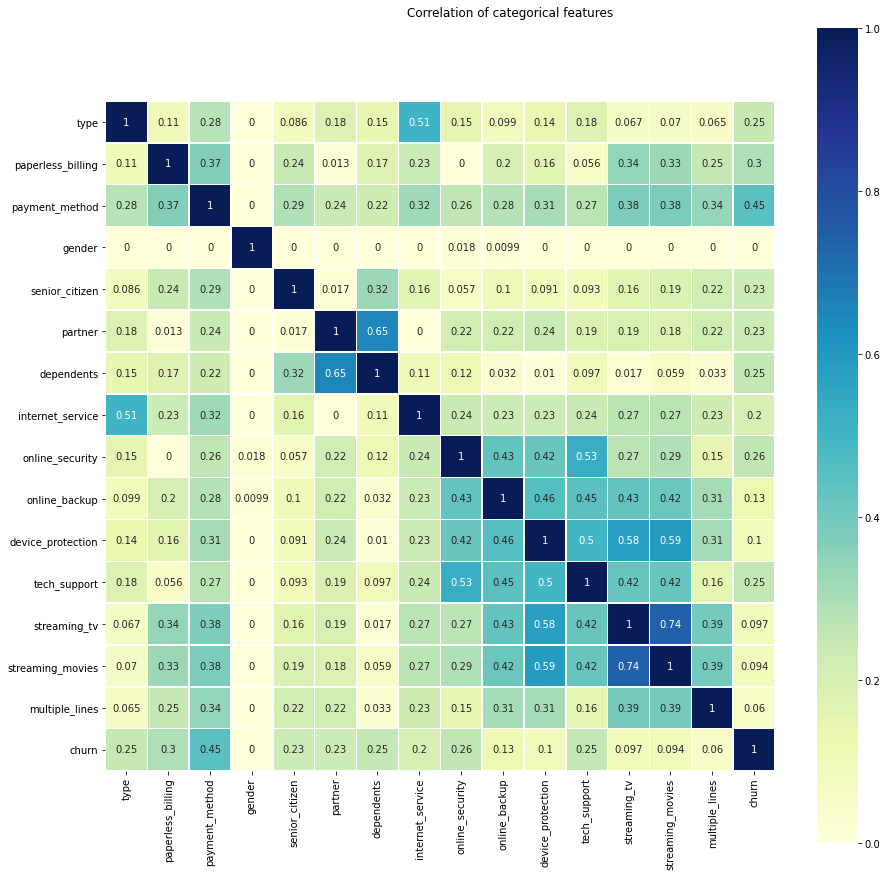

In [38]:
fig, ax = plt.subplots(figsize = (15,15)) 

sns.heatmap(phik_mtrx, annot = True, linewidths=.5, cmap="YlGnBu", square=True, ax = ax)
plt.suptitle("Correlation of categorical features", y=0.9)
plt.show()

**Build a scatter diagram**

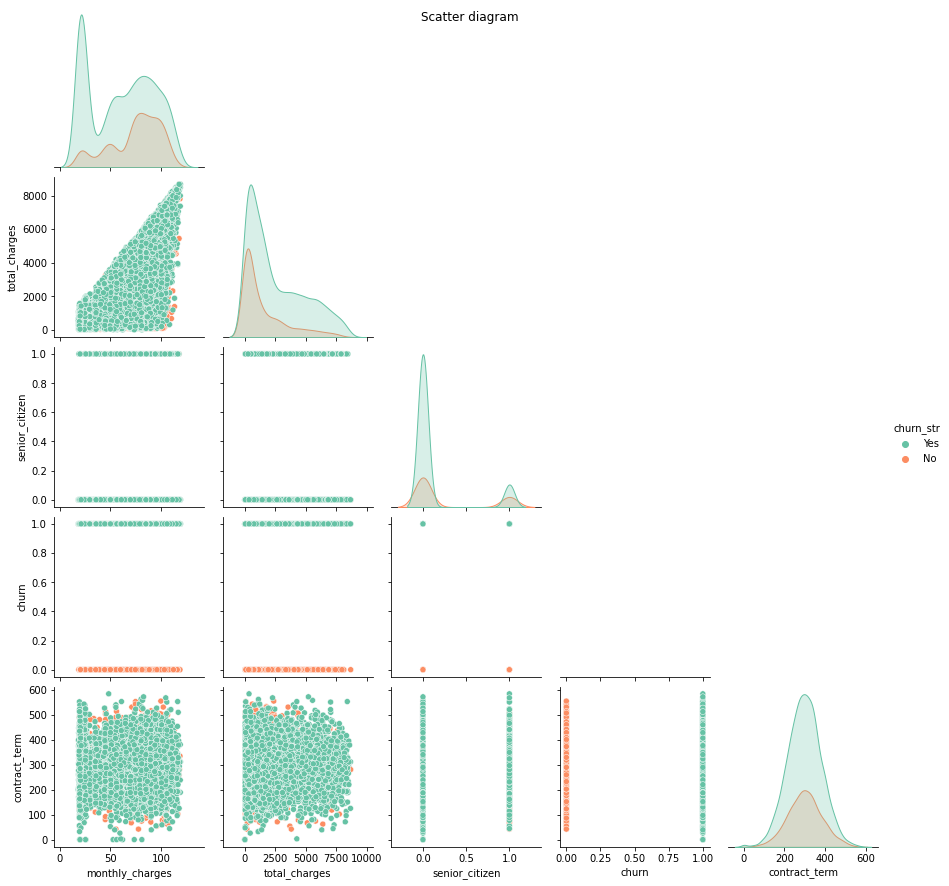

In [39]:
sns.pairplot(df, hue = 'churn_str' ,corner = True, palette = 'Set2')
plt.suptitle("Scatter diagram")
plt.show()

We couldn't find anything interesting here.

In [40]:
df = df.drop('churn_str', axis = 1)

### Preparing features for model training

Next, we prepare the data for training, we produce:
   - scaling quantitative features
   - categorical variable coding (OHE)
   - split the sample into train and test

In [41]:
cat_cols_ohe = df.columns[~df.columns.isin(cat_cols)]
cat_cols_ohe = [x for x in cat_cols if x != 'churn']

df_ready = df.copy()

**Split data into train and test**

- for decision tree and boosting, we will divide the sample into two parts

In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    df_ready.drop(columns = ['churn', 'customer_id']), 
    df_ready.churn, 
    test_size = 0.3, 
    random_state = 12345)

print('Test share ', round(len(X_test)/len(df),3))
print('Train share ', round(len(X_train)/len(df),3)) 

Test share  0.3
Train share  0.7


- for a neural network into three parts (+ validation)

In [43]:
X_nn, X_test_nn, y_nn, y_test_nn = train_test_split(
    df_ready.drop(columns = ['churn', 'customer_id']), 
    df_ready.churn, 
    test_size = 0.20, 
    random_state = 12345)

X_train_nn, X_valid_nn, y_train_nn, y_valid_nn = train_test_split(
    X_nn,
    y_nn,
    test_size = 0.25)

print('Test share ', round(len(X_test_nn)/len(df_ready),3))
print('Valid share ', round(len(X_valid_nn)/len(df_ready),3))
print('Train share ', round(len(X_train_nn)/len(df_ready),3)) 

Test share  0.2
Valid share  0.2
Train share  0.6


**Scaling features**

In [44]:
scaler = StandardScaler()

- for decision tree

In [45]:
X_train_dt = X_train.copy()
X_test_dt = X_test.copy()

for col in numerical_cols:

    scaler.fit(X_train_dt[[col]]) 

    X_train_dt['sc_' + str(col)] = scaler.transform(X_train_dt[[col]])
    X_test_dt['sc_' + str(col)] = scaler.transform(X_test_dt[[col]])

- for a neural network

In [46]:
X_train_nn = X_train_nn.copy()
X_valid_nn = X_valid_nn.copy()
X_test_nn = X_test_nn.copy()

for i in numerical_cols:

    scaler.fit(X_train_nn[[col]]) 

    X_train_nn['sc_' + str(col)] = scaler.transform(X_train_nn[[col]])
    X_valid_nn['sc_' + str(col)] = scaler.transform(X_valid_nn[[col]])
    X_test_nn['sc_' + str(col)] = scaler.transform(X_test_nn[[col]])

**OneHotEncoder** 

In [47]:
ohe = OneHotEncoder(handle_unknown = 'ignore', sparse = False)

In [48]:
cat_cols_ohe = df.columns[~df.columns.isin(cat_cols)]
cat_cols_ohe = [x for x in cat_cols if x != 'churn']

cat_cols_ohe

['type',
 'paperless_billing',
 'payment_method',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines']

- for decision tree and boosting

In [49]:
feature_arr = ohe.fit_transform(X_train[cat_cols_ohe])
feature_labels = ohe.get_feature_names(cat_cols_ohe)

features_train = pd.DataFrame(feature_arr, columns = feature_labels)

features_train.shape

(4930, 34)

In [50]:
features_arr = ohe.transform(X_test[cat_cols_ohe])
features_test = pd.DataFrame(features_arr, columns = feature_labels)

features_test.shape

(2113, 34)

In [51]:
features_train.columns[:5]

Index(['type_Month-to-month', 'type_One year', 'type_Two year',
       'paperless_billing_No', 'paperless_billing_Yes'],
      dtype='object')

In [52]:
print(X_train.shape)
print(X_test.shape)

(4930, 18)
(2113, 18)


In [53]:
X_train_dt = pd.concat([X_train, features_train.set_index(X_train.index)], axis=1).copy()
X_test_dt = pd.concat([X_test, features_test.set_index(X_test.index)], axis=1).copy()

print(X_train_dt.shape)
print(X_test_dt.shape)

(4930, 52)
(2113, 52)


- for a neural network

In [54]:
feature_arr_nn = ohe.fit_transform(X_train_nn[cat_cols_ohe])
feature_labels_nn = ohe.get_feature_names(cat_cols_ohe)

features_train_nn = pd.DataFrame(feature_arr_nn, columns = feature_labels_nn)

features_train_nn.shape

(4225, 34)

In [55]:
features_arr_nn = ohe.transform(X_valid_nn[cat_cols_ohe])
features_valid_nn = pd.DataFrame(features_arr_nn, columns = feature_labels_nn)

features_valid_nn.shape

(1409, 34)

In [56]:
features_arr_nn = ohe.transform(X_test_nn[cat_cols_ohe])
features_test_nn = pd.DataFrame(features_arr_nn, columns = feature_labels_nn)

features_test_nn.shape

(1409, 34)

In [57]:
print(X_train_nn.shape)
print(X_valid_nn.shape)
print(X_test_nn.shape)

(4225, 19)
(1409, 19)
(1409, 19)


In [58]:
X_train_nn = pd.concat([X_train_nn, features_train_nn.set_index(X_train_nn.index)], axis=1).copy()
X_valid_nn = pd.concat([X_valid_nn, features_valid_nn.set_index(X_valid_nn.index)], axis=1).copy()
X_test_nn = pd.concat([X_test_nn, features_test_nn.set_index(X_test_nn.index)], axis=1).copy()

print(X_train_nn.shape)
print(X_valid_nn.shape)
print(X_test_nn.shape)

(4225, 53)
(1409, 53)
(1409, 53)


**We collect samples for different models**

- decision tree

In [59]:
X_train_dt = X_train_dt.drop(numerical_cols + cat_cols_ohe, axis = 1).copy()
X_test_dt = X_test_dt.drop(numerical_cols + cat_cols_ohe, axis = 1).copy()

y_train_dt = y_train.copy()
y_test_dt = y_test.copy()

In [60]:
X_train_dt.head(3)

,type_Month-to-month,type_One year,type_Two year,paperless_billing_No,paperless_billing_Yes,payment_method_Bank transfer (automatic),payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,gender_Female,...,device_protection_No,device_protection_Yes,tech_support_No,tech_support_Yes,streaming_tv_No,streaming_tv_Yes,streaming_movies_No,streaming_movies_Yes,multiple_lines_No,multiple_lines_Yes
99,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
5684,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4627,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


- boosting

In [61]:
X_train_bst = X_train.copy()
X_test_bst = X_test.copy()

y_train_bst = y_train.copy()
y_test_bst = y_test.copy()

In [62]:
X_train_bst.head(3)

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,contract_term
99,Month-to-month,Yes,Electronic check,41.90,840.10,Female,1,No,No,DSL,Yes,No,No,No,Yes,No,No,269
5684,Month-to-month,No,Bank transfer (automatic),19.45,159.20,Male,0,No,Yes,No,No,No,No,No,No,No,No,343
4627,One year,Yes,Bank transfer (automatic),88.80,5903.15,Male,0,No,No,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Yes,276


- neural network

In [63]:
X_train_nn = X_train_nn.drop(numerical_cols + cat_cols_ohe, axis = 1).copy()
X_valid_nn = X_valid_nn.drop(numerical_cols + cat_cols_ohe, axis = 1).copy()
X_test_nn = X_test_nn.drop(numerical_cols + cat_cols_ohe, axis = 1).copy()

y_train_nn = y_train_nn.copy()
y_valid_nn = y_valid_nn.copy()
y_test_nn = y_test_nn.copy()

In [64]:
X_train_nn.head(3)

,sc_contract_term,type_Month-to-month,type_One year,type_Two year,paperless_billing_No,paperless_billing_Yes,payment_method_Bank transfer (automatic),payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,...,device_protection_No,device_protection_Yes,tech_support_No,tech_support_Yes,streaming_tv_No,streaming_tv_Yes,streaming_movies_No,streaming_movies_Yes,multiple_lines_No,multiple_lines_Yes
1329,0.602952,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3328,0.284935,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
6386,-1.246260,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [65]:
X_train_nn = torch.FloatTensor(X_train_nn.values)
X_valid_nn = torch.FloatTensor(X_valid_nn.values)
X_test_nn = torch.FloatTensor(X_test_nn.values)

y_train_nn = torch.FloatTensor(y_train_nn.values)
y_valid_nn = torch.FloatTensor(y_valid_nn.values)
y_test_nn = torch.FloatTensor(y_test_nn.values)

**Conclusion**

This phase of the study consisted of two parts:

**EDA**.

At this stage, we studied our data in detail and looked for patterns in them.
- checked the fullness of the tables and the presence of a common key for linking data into a single table
- fixed CamelCase to snake_case in column names
- checked obvious duplicates and processed omission based on the logic of filling tables
- selected target
- added new feature `contract_term`
- studied categorical and quantitative variables in detail
   - looked at the distributions of quantities, plotted range diagrams for quantitative variables
   - looked at the distribution by the target

**Preparing data for training**.
Prepared data depending on the models used
- carried out scaling of quantitative signs
- carried out coding of categorical features
- split the dataset into a train and a test part

##  Model training

**ML problem statement**

**Main objective of the project:**

A telecom operator wants to learn how to predict customer churn.
There is historical data with a sign of churn.

**Target variable:**

Based on the statement of the problem, it follows that we will predict the indicator **`churn`**

**What type of problem is solved:**

A binary feature is predicted, we solve a classification problem

**Quality metric:**

Given by condition
- optimize by `ROC-AUC` > 0.78
- also display `accuracy`

### **DecisionTree**

In [66]:
model_dtc = DecisionTreeClassifier(random_state = 12345, class_weight = 'balanced')

**GridSearchCV** - we need it to search for optimal hyperparameters.

In fact, this is a grid search for different values, the combination where the metric value will be maximum.

In [67]:
param_grid_dtc = { 
    'max_depth' : [3,4,5,6,7,8,9,10,11,12,13,14,15,20,30,50]
}

In [68]:
%%time
t1 = datetime.datetime.now()


CV_dtc = GridSearchCV(estimator = model_dtc, param_grid = param_grid_dtc, cv = 5, 
                                                  scoring = 'roc_auc')
CV_dtc.fit(X_train_dt, y_train_dt)

print("Best param DTC")
print(CV_dtc.best_params_)

model_dtc.set_params(**CV_dtc.best_params_)

scores_dtc = np.array([])

fold = KFold(n_splits = 5 , shuffle = True, random_state = 12345)

scores_on_this_split = cross_val_score(
            estimator = model_dtc , X = X_train_dt, y = y_train_dt,
            cv = fold, scoring = 'roc_auc')
scores_dtc = np.append(scores_dtc, scores_on_this_split)

t2 = datetime.datetime.now()

time_dtc_cv = round((t2-t1).total_seconds(), 1)

Best param DTC
{'max_depth': 4}
CPU times: user 1.9 s, sys: 2.37 ms, total: 1.91 s
Wall time: 1.95 s


In [69]:
print(scores_dtc.mean())

0.8086629930773238


Train the model

In [70]:
%%time

t1 = datetime.datetime.now()

model_dtc.fit(X_train_dt, y_train_dt)

t2 = datetime.datetime.now()

time_dtc_fit = round((t2-t1).total_seconds(), 1)

CPU times: user 21.3 ms, sys: 103 µs, total: 21.4 ms
Wall time: 20 ms


Making a prediction

In [71]:
%%time

t1 = datetime.datetime.now()

predicted_target_test_dtc = model_dtc.predict(X_test_dt)
predicted_target_test_dtc_roc = model_dtc.predict_proba(X_test_dt)[:, 1]

t2 = datetime.datetime.now()

time_dtc_prd = round((t2-t1).total_seconds(), 1)

CPU times: user 10.6 ms, sys: 0 ns, total: 10.6 ms
Wall time: 9.11 ms


In [72]:
print("DecisionTree roc_auc_score:", roc_auc_score(y_test_dt, predicted_target_test_dtc_roc))
print("DecisionTree accuracy_score:", accuracy_score(y_test_dt, predicted_target_test_dtc))

DecisionTree roc_auc_score: 0.8158342285294284
DecisionTree accuracy_score: 0.7340274491244676


### **CatBoost**

In [73]:
from sklearn.utils.class_weight import compute_class_weight
 
classes = np.unique(y_train_bst)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_bst)
class_weights = dict(zip(classes, weights))

In [74]:
model_catbst = CatBoostClassifier(random_state = 12345, 
                                 verbose = False, 
                                 class_weights = class_weights,
                                 cat_features = cat_cols_ohe) 

In [75]:
'''param_grid_catbst = {
    'learning_rate': [0.01, 0.1, 0.3],
    'depth': range(6, 11, 2),
    'l2_leaf_reg': range(3, 10, 2),
}'''

param_grid_catbst = {'learning_rate':[0.01, 0.1, 0.3]}

In [76]:
%%time

t1 = datetime.datetime.now()

CV_catbst = GridSearchCV(estimator = model_catbst, param_grid = param_grid_catbst, cv = 5, 
                                                  scoring = 'roc_auc')
CV_catbst.fit(X_train_bst, y_train_bst)

print("Best param Catbst")
print(CV_catbst.best_params_)

model_catbst.set_params(**CV_catbst.best_params_)

scores_catbst = np.array([])

fold = KFold(n_splits = 5 , shuffle = True, random_state = 12345)

scores_on_this_split = cross_val_score(
            estimator = model_catbst , X = X_train_bst, y = y_train_bst,
            cv = fold, scoring = 'roc_auc')
scores_catbst = np.append(scores_catbst, scores_on_this_split)

t2 = datetime.datetime.now()

time_catbst_cv = round((t2-t1).total_seconds(), 1)

Best param Catbst
{'learning_rate': 0.01}
CPU times: user 46min 44s, sys: 12min 38s, total: 59min 22s
Wall time: 2min 9s


Train the model

In [77]:
%%time

t1 = datetime.datetime.now()

model_catbst.fit(X_train_bst, y_train_bst)

t2 = datetime.datetime.now()

time_catbst_fit = round((t2-t1).total_seconds(), 1)

CPU times: user 2min 10s, sys: 36.9 s, total: 2min 47s
Wall time: 6.43 s


Making a prediction

In [78]:
%%time

t1 = datetime.datetime.now()

predicted_target_test_catbst = model_catbst.predict(X_test_bst)
predicted_target_test_catbst_roc = model_catbst.predict_proba(X_test_bst)[:, 1]

t2 = datetime.datetime.now()

time_catbst_prd = round((t2-t1).total_seconds(), 1)

CPU times: user 61.8 ms, sys: 4.16 ms, total: 66 ms
Wall time: 23.7 ms


In [79]:
print("CatBoost roc_auc_score:", roc_auc_score(y_test_bst, predicted_target_test_catbst_roc))
print("CatBoost accuracy_score:", accuracy_score(y_test_bst, predicted_target_test_catbst))

CatBoost roc_auc_score: 0.853243059874484
CatBoost accuracy_score: 0.7628963558920966


### **LightGBM**

In [80]:
model_lgbm = LGBMClassifier(random_state = 12345,
                              class_weight = class_weights
                            )

In [81]:
param_grid_lgbm = {'learning_rate':[0.01, 0.1, 0.3]}

In [82]:
%%time

t1 = datetime.datetime.now()

CV_lgbm = GridSearchCV(estimator = model_lgbm, param_grid = param_grid_lgbm, cv = 5, 
                                                  scoring = 'roc_auc')
CV_lgbm.fit(X_train_dt, y_train_dt)

print("Best param LightGBM")
print(CV_lgbm.best_params_)

model_lgbm.set_params(**CV_lgbm.best_params_)

scores_lgbm = np.array([])

fold = KFold(n_splits = 5 , shuffle = True, random_state = 12345)

scores_on_this_split = cross_val_score(
            estimator = model_lgbm , X = X_train_dt, y = y_train_dt,
            cv = fold, scoring = 'roc_auc')
scores_lgbm = np.append(scores_lgbm, scores_on_this_split)

t2 = datetime.datetime.now()

time_lgbm_cv = round((t2-t1).total_seconds(), 1)

Best param LightGBM
{'learning_rate': 0.01}
CPU times: user 1min 22s, sys: 867 ms, total: 1min 23s
Wall time: 4.97 s


Train the model

In [83]:
%%time

t1 = datetime.datetime.now()

model_lgbm.fit(X_train_dt, y_train_dt)

t2 = datetime.datetime.now()

time_lgbm_fit = round((t2-t1).total_seconds(), 1)

CPU times: user 4.52 s, sys: 33.5 ms, total: 4.55 s
Wall time: 237 ms


Making a prediction

In [84]:
%%time

t1 = datetime.datetime.now()

predicted_target_test_lgbm = model_lgbm.predict(X_test_dt)
predicted_target_test_lgbm_roc = model_lgbm.predict_proba(X_test_dt)[:, 1]

t2 = datetime.datetime.now()

time_lgbm_prd = round((t2-t1).total_seconds(), 1)

CPU times: user 115 ms, sys: 0 ns, total: 115 ms
Wall time: 10.3 ms


In [85]:
print("LightGBM roc_auc_score:", roc_auc_score(y_test_dt, predicted_target_test_lgbm_roc))
print("LightGBM accuracy_score:", accuracy_score(y_test_dt, predicted_target_test_lgbm))

LightGBM roc_auc_score: 0.8262531803019166
LightGBM accuracy_score: 0.7245622337908187


### **Neural network**

In [86]:
INPUT_SIZE = X_train_nn.shape[1]
HIDDEN_SIZE = 50
HIDDEN_SIZE_2 = 20
NUM_CLASSES = 1

NUM_EPOCHS = 2000
LEARNING_RATE = 0.001

In [87]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size,hidden_size_2,num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size_2) 
        self.act2 = nn.Sigmoid()
        self.fc3 = nn.Linear(hidden_size_2, num_classes) 
        self.act3 = nn.Sigmoid()
        
     
    def forward(self, x):
        out = self.fc1(x)
        out = self.act1(out)
        out = self.fc2(out)
        out = self.act2(out)
        out = self.fc3(out)
        out = self.act3(out)
        return out

In [88]:
model_nn = NeuralNet(INPUT_SIZE, HIDDEN_SIZE, HIDDEN_SIZE_2, NUM_CLASSES)

In [89]:
model_nn

NeuralNet(
  (fc1): Linear(in_features=35, out_features=50, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=50, out_features=20, bias=True)
  (act2): Sigmoid()
  (fc3): Linear(in_features=20, out_features=1, bias=True)
  (act3): Sigmoid()
)

Далее напишем функцию для обучения модели, на вход будем подавать число эпох и шаг расчета метрики, а также саму модель

In [90]:
def predict_nn(md, features_test, target_test=None):
    md.eval()
    preds_test = md.forward(features_test)
    preds_test = (preds_test.detach().numpy())
    if target_test is not None:
        y_inx_test = pd.DataFrame(target_test)
        y_inx_test.columns = ['churn']
        y_inx_test['churn_pred'] = preds_test
        y_inx_test = y_inx_test.reset_index()
        y_inx_test['churn_pred_bnry'] = np.where(y_inx_test['churn_pred'] > 0.5, 1, 0)
        roc_auc = roc_auc_score(y_inx_test[['churn']], y_inx_test[['churn_pred']])
        accuracy = accuracy_score(y_inx_test[['churn']], y_inx_test[['churn_pred_bnry']])

    else:
        roc_auc = None
        accuracy = None
    return preds_test, roc_auc, accuracy

In [91]:
def fit_nn(md, n_epoch, step_epoch):
    
    t1 = datetime.datetime.now()
    
    loss = nn.BCELoss()

    optimizer = torch.optim.Adam(md.parameters(), lr = LEARNING_RATE) 
    
    roc_auc_prev = 0
    
    for epoch in range(n_epoch):

        optimizer.zero_grad()

        preds = md.forward(X_train_nn).flatten()

        loss_value = loss(preds, y_train_nn)

        loss_value.backward()

        optimizer.step()

        if epoch % step_epoch == 0 or epoch == n_epoch - 1:
            
            preds_test, roc_auc, accuracy = predict_nn(md=md, features_test = X_valid_nn, target_test = y_valid_nn)

            if roc_auc < roc_auc_prev or roc_auc_prev == 0: 
            
                roc_auc_prev = roc_auc
                 
            else:
                break
         
    
    t2 = datetime.datetime.now()
    
    time_lr = round((t2-t1).total_seconds(), 1)

    data = {
           'epoch': [str(epoch + 1) + '/' + str(n_epoch)],
           'loss_value': [np.round(loss_value.data.numpy(), 2)],
           'ROC_AUC': [round(roc_auc,2)],
           'accuracy': [accuracy],
           'time_calc': [time_lr]
           }
 
    res_dt = pd.DataFrame(data)
    
    print ('epoch [{}/{}], loss_value: {:.4f} ROC_AUC: {:.4f}, accuracy: {:.4f}, time_calc: {}' 
                           .format(epoch + 1, n_epoch, loss_value, roc_auc, accuracy, time_lr))
            
    return preds_test, res_dt

In [92]:
model_nn = NeuralNet(INPUT_SIZE, HIDDEN_SIZE, HIDDEN_SIZE_2, NUM_CLASSES)
result, dt_end = fit_nn(model_nn, 2000, 200)

epoch [201/2000], loss_value: 0.4410 ROC_AUC: 0.8336, accuracy: 0.7878, time_calc: 1.2


In [93]:
dt_end

,epoch,loss_value,ROC_AUC,accuracy,time_calc
0,201/2000,0.44,0.83,0.787793,1.2


In [94]:
preds_test_nn, roc_auc_nn, accuracy_nn = predict_nn(model_nn, X_test_nn, y_test_nn)

print('Neural Network roc_auc: ', roc_auc_nn)
print('Neural Network accuracy: ', accuracy_nn)

Neural Network roc_auc:  0.8290924522854213
Neural Network accuracy:  0.7920511000709723


In [95]:
index = ['DecisionTree',
         'CatBoost',
         'LGBM',
         'Neural Network']

data = ({'ROC_AUC_valid':[round(scores_dtc.mean(),5),
                    round(scores_catbst.mean(),5),
                    round(scores_lgbm.mean(),5),
                    round(dt_end['ROC_AUC'][0],5)
                    ],
    
        'ROC_AUC_test':[round(roc_auc_score(y_test_dt, predicted_target_test_dtc_roc),5),
                    round(roc_auc_score(y_test_bst, predicted_target_test_catbst_roc),5),
                    round(roc_auc_score(y_test_dt, predicted_target_test_lgbm_roc),5),
                    round(roc_auc_nn, 5)
                    ],
                           

       
        'Accuracy_test':[round(accuracy_score(y_test_dt, predicted_target_test_dtc),4),
                    round(accuracy_score(y_test_bst, predicted_target_test_catbst),4),
                    round(accuracy_score(y_test_dt, predicted_target_test_lgbm),4),
                    round(accuracy_nn, 4)
                    ]
})
  

models_result = pd.DataFrame(data=data, index=index)

**Summary table with the results of all models**

In [96]:
models_result

,ROC_AUC_valid,ROC_AUC_test,Accuracy_test
DecisionTree,0.80866,0.81583,0.7340
CatBoost,0.84502,0.85324,0.7629
LGBM,0.81986,0.82625,0.7246
Neural Network,0.83000,0.82909,0.7921


**Output**
- formulated ML task
- designated the target metric (set according to the condition of the problem)
- models trained in the project:
   - DesicionTree
   - CatBoost
   - LightGBM
   - Neural network
- carried out the selection of hyperparameters
- did cross-validation
- made a prediction on test data for all four models
- the final results were entered in a summary table

**Best model selection**

This is probably going to sound trite, but it's CatBoost again.
All results were very close, without fundamental differences in accuracy.
At the same time, CatBoost again works essentially "out of the box" - its test and train set is just an initial dataset split into two parts (no scaling was applied to it).
Labor costs in case of its use is a well-conducted EDA.

## Testing the model and demonstrating how it works

Now let's take a closer look at our best model.

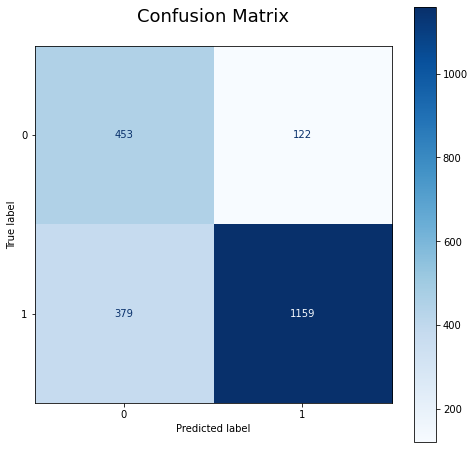

In [97]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(8, 8))

#ConfusionMatrixDisplay.from_estimator(
#    model_catbst, X_test_bst, y_test_bst, cmap = plt.cm.Blues ,ax = ax, colorbar=True)
plot_confusion_matrix(model_catbst, X_test_bst, y_test_bst, cmap = plt.cm.Blues, ax = ax)

plt.title('Confusion Matrix',  fontsize = 18, y = 1.05)
plt.show()

- 411 **True Negative (TN)** - churn - no, predict - no
- 164 **False positive (FP)** - churn - no, predict - yes
- 296 **False negative (FN)** - churn - yes, predict - no
- 1242 **True positive (TP)** - churn - yes, predict - yes

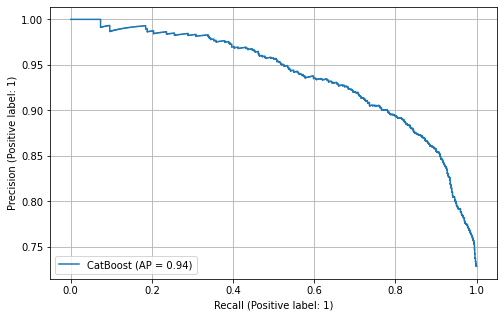

In [98]:
from sklearn.metrics import plot_precision_recall_curve

fig, ax = plt.subplots(figsize=(8, 5))
#PrecisionRecallDisplay.from_estimator(model_catbst, X_test_bst, y_test_bst, name = 'CatBoost', ax=ax)
plot_precision_recall_curve(model_catbst, X_test_bst, y_test_bst, name = 'CatBoost', ax=ax)
plt.grid(True)
plt.show()

Next, let's see the feature importance on the trained model

In [99]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data = {'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    
    plt.figure(figsize=(8,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + ' feature importance')
    plt.xlabel('feature importance')
    plt.ylabel('feature names')
    plt.grid(True)

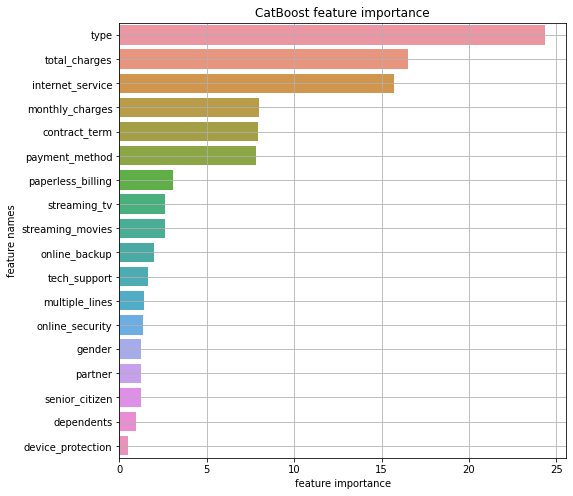

In [100]:
plot_feature_importance(model_catbst.get_feature_importance(), X_train_bst.columns,'CatBoost')

I would like to note that the TOP-5 important features included all the insiders noted earlier at the EDA stage,  
as well as a feature created at the same stage.

Features related to payments
- `type` — payment type (once a year or monthly)
- `total_charges` 
- `monthly_charges`

Additional features
- `internet_service` — connection type
- `contract_term` - contract duration

Let's show a graph of the dependence of the variables and the target variable.

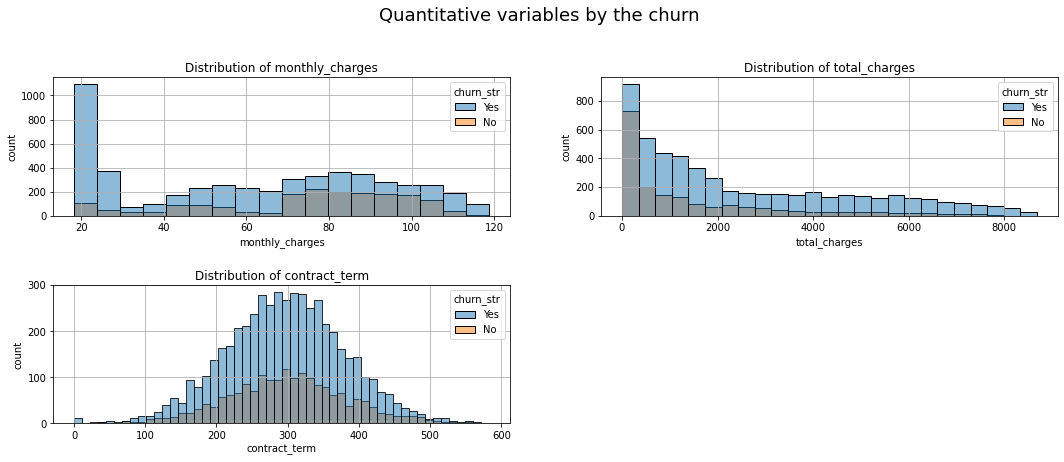

In [101]:
df['churn_str'] = np.where(df['churn'] == 1, 'Yes', 'No')

plt.figure(figsize = (18, 14))
plt.subplots_adjust(hspace = 0.5)
plt.suptitle("Quantitative variables by the churn", fontsize = 18, y = 0.95)

for n, ct in enumerate(numerical_cols):
    ax = plt.subplot(4, 2, n + 1)
    ax = sns.histplot(data=df, x=ct, hue="churn_str")
    plt.title(f'Distribution of {ct}')
    plt.xlabel(ct)
    plt.ylabel('count')
    plt.grid(True)


plt.grid(True)
plt.show()

- the difference in income by the target feature is obvious - the profiles of the charts are different (this can be seen especially well on the chart of the `monthly_charges` feature)
- the distribution of `contract_term` itself is not very indicative, I think it’s about the totality of factors and we won’t be able to visually visualize this (the case when the algorithm sees better than a person =)

CPU times: user 238 ms, sys: 11.5 ms, total: 249 ms
Wall time: 246 ms


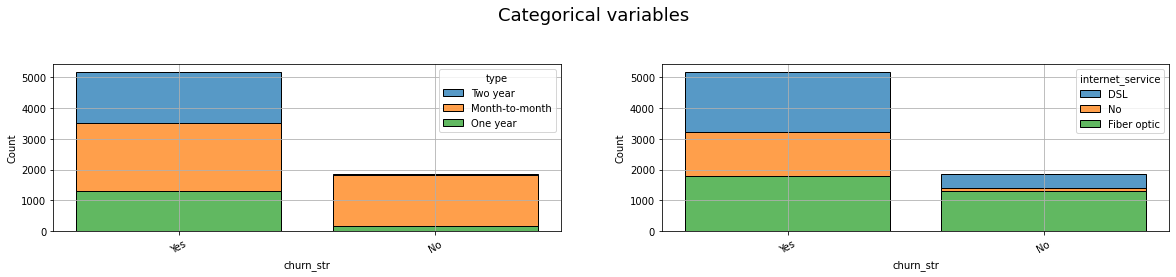

In [102]:
%%time

plt.figure(figsize = (20, 40))
plt.subplots_adjust(hspace = 0.5)
plt.suptitle("Categorical variables", fontsize = 18,  y=0.9)

for n, ct in enumerate(['type','internet_service']):
    ax = plt.subplot(9, 2, n + 1)
    sns.histplot(df, x='churn_str', hue=ct, multiple='stack', shrink=.8, ax = ax)
    ax.tick_params(axis = 'x', labelrotation = 30)
    plt.grid(True)

In [103]:
print('Minimum contract start date', df_contract['BeginDate'].min())

Minimum contract start date 2018-04-17


- Churn is less likely if paid monthly. I emphasize that we have a data depth of 2 years, so the outflow for 2- and 1-years can be shifted (for long contracts, this is only 1 payment)
- Visualized churn for customers who do not use the Internet or use DSL (quite old technology)

We could assume that the company is changing its strategy and customers without the Internet enter into new contracts, but there are no duplicates in the tables by customer_id, this is not a renegotiation of contracts, but a loss.

**Conclusion:**

In this section of the study, we looked at the best model:
   - built an error matrix and a PR curve
   - assessed the importance of features
   - examined in detail the dependences of the TOP-5 most important features on the target variable

In [104]:
models_result

,ROC_AUC_valid,ROC_AUC_test,Accuracy_test
DecisionTree,0.80866,0.81583,0.7340
CatBoost,0.84502,0.85324,0.7629
LGBM,0.81986,0.82625,0.7246
Neural Network,0.83000,0.82909,0.7921


##  General conclusion

In this project, a model was created to predict the outflow of customers of a telecom operator

The project included the following stages:
  - primary study of tables
      - database connection
      - a brief overview of the tables available in the database (reconciliation of their contents with the business condition)
  - preprocessing
      - collection of dataset for model training
      - selection of traits involved in modeling (+adding additional features)
      - work with duplicates and omissions
  - exploratory data analysis
      - study of quantitative and categorical features
      - analysis of dependences in data on the target feature
  - preparing data for the churn forecasting model
      - scaling of quantitative and coding of categorical features
      - split into train and test parts
  - training and search for the best model
      - based on the requirements of the customer, we formulated an ML task
         - set target and target metrics
      - DecisionTree, CatBoost, LGBM, Neural Network models were trained
         - carried out the selection of hyperparameters
         - did cross-validation
         - carried out a prediction for all four models
         - compared models in terms of quality on the target metric

   - results:

<div align="center">

| |	ROC_AUC| Accuracy|
|---|---|---|
|DecisionTree |	0.8158| 0.7340|
|CatBoost |	0.8532| 0.7629|
|LGBM |	0.8262| 0.7246|
|Neural Network |	0.8300| 0.7921|

</div>

- performance evaluation of the best model
     - built a confusion matrix and a PR curve
     - assessed the feature importance
     - considered in detail the impact of the TOP-5 important features on the target


**Important Observations**

- Among those who pay monthly, the share of refusals is approximately equal, and among payments for a year or two - the maximum
- Clients close contracts without drawing up new contracts
- Churn is more pronounced for customers with minimal monthly charges `montly_charges`
- Most often clients close contracts without internet or with DSL
- All other additional services do not affect the target - proportionally failures are the same everywhere. Although indirectly they lie in the monthly and general payments under the contract.

**General recommendations**

- work with clients on long contracts before the end of the paid period
- work with clients with the cheapest contracts (providing additional options and services, since this has little effect on the outflow)
- providing customers without Internet or with DSL new services to already existing contracts or / and their reorientation to new contracts with a different set of options
 
**Final model**

According to the formal condition ROC_AUC > 0.78, all models passed.
The choice is based on personal preference.

catboost:
   - `learning_rate` - 0.001
   - `ROC_AUC` - 0.8532
   - `Accuracy` - 0.7629